In [1]:
import numpy as np
import numba
import incoef
import matplotlib.pyplot as plt
from time import perf_counter

In [2]:
eps = np.finfo(np.float64).eps

def ismall(z, reference = 1.0):
    return np.abs(z) <= reference * eps

In [3]:
class Element:
    """Straight segment constant boundary element.

    Parameters
    ----------
    point1 : numpy.ndarray
        First end point global coordinates.
    point2 : numpy.ndarray
        Second end point global coordinates.
        
    Attributes
    ----------
    endpoints : numpy.ndarray
        Element end points' global coordinates.
    node : numpy.ndarray
        Midpoint between endpoints.
    length : float
        Element's length.
    tangent : numpy.ndarray
        Element's tangent vector.
    normal : numpy.ndarray
        Element's normal vector.

    Methods
    -------
    get_point_local_coordinates(point_global)
        Get point's coordinates in local system.
    get_point_distance(point_global)
        Get point's distance from the element.
    get_influence_coefficients(field_global, method='analytical', boost=None)
        Get influence coefficients at a field point.
    """

    def __init__(self, point1, point2):
        self.endpoints = np.array([point1, point2])
        self.node = self.endpoints.mean(axis=0)

        r = self.endpoints[1] - self.endpoints[0]
        self.length = np.linalg.norm(r)
        self.tangent = r / self.length
        self.normal = np.array([self.tangent[1], -self.tangent[0]])
        
    def get_point_local_coordinates(self, point_global):
        """Get point's coordinates in local system.

        Parameters
        ----------
        point_global : numpy.ndarray
            Point's coordinates in global system.

        Returns
        -------
        point_local : numpy.ndarray
            Point's coordinates in local system.
        """

        dif = np.array(point_global) - self.node
        x = np.dot(dif, self.tangent)
        y = np.dot(dif, self.normal)
        point_local = np.array([x, y])

        return point_local

    def get_point_distance(self, point_global):
        """Get point's distance from the element.
        
        Parameters
        ----------
        point_global : numpy.ndarray
            Point's coordinates in global system.

        Returns
        -------
        distance : float
            Point's distance from the element.
        """

        a = 0.5 * self.length
        x, y = self.get_point_local_coordinates(point_global)

        if np.abs(x) <= a:
            distance = np.abs(y)
        else:
            dif_from_endpoints = point_global - self.endpoints
            distance_from_endpoints = np.linalg.norm(dif_from_endpoints, axis=1)
            distance = distance_from_endpoints.min()

        return distance
    
    def get_influence_coefficients(
        self, field_global, method = 'analytical', boost = None
    ):
        """Get influence coefficients at a field point.

        Parameters
        ----------
        field_global : numpy.ndarray
            Field point's coordinates in global system.
        method : string, default='analytical'
            Evaluation method of line integrals. Two methods are available:
            'analytical' and 'gauss'.
        boost : string, default=None
            Boosting method to increase computation speed. Two methods are available:
            'numba' and 'fortran'.

        Returns
        -------
        G : float
            Integral of the Green's function over the element.
        Q : float
            Integral of the Green's function normal derivative over the element.

        Raises
        ------
        ValueError
            If integration method is invalid.
        ValueError
            If boosting method is invalid.
        """

        x, y = self.get_point_local_coordinates(field_global)

        if ismall(x, self.length) and ismall(y, self.length):
            a = 0.5 * self.length
            G = a / np.pi * (np.log(a) - 1)
            Q = 0.0

            return G, Q
        
        _method = method.strip().lower()
        _boost = None if boost is None else boost.strip().lower()

        if _method == 'analytical':
            if _boost is None:
                G, Q = self.get_influence_coefficients_analytical(field_global)
            elif _boost == 'numba':
                G, Q = self.get_influence_coefficients_analytical_numba(field_global)
            elif _boost == 'fortran':
                G, Q = self.get_influence_coefficients_analytical_fortran(field_global)
            else:
                raise ValueError(f"Invalid boosting method: {boost}")
        elif _method == 'gauss':
            if _boost is None:
                G, Q = self.get_influence_coefficients_gauss(field_global)
            elif _boost == 'numba':
                G, Q = self.get_influence_coefficients_gauss_numba(field_global)
            elif _boost == 'fortran':
                G, Q = self.get_influence_coefficients_gauss_fortran(field_global)
            else:
                raise ValueError(f"Invalid boosting method: {boost}")
        else:
            raise ValueError(f"Invalid integration method: {method}")

        return G, Q
    
    def get_influence_coefficients_analytical(self, field_global):
        a = 0.5 * self.length
        field_local = self.get_point_local_coordinates(field_global)
        x, y = field_local

        if ismall(y, self.length) and ismall(np.abs(x) - a, self.length):
            G = a / np.pi * (np.log(2*a) - 1)
            Q = 0.0
        else:
            xpa = x + a
            xma = x - a

            r1 = np.sqrt(xma**2 + y**2)
            r2 = np.sqrt(xpa**2 + y**2)
            t1 = np.arctan2(y, xma)
            t2 = np.arctan2(y, xpa)
    
            G = 0.5 / np.pi * (
                y * (t1 - t2) - xma * np.log(r1) + xpa * np.log(r2) - 2 * a
            )

            if ismall(y, self.length):
                # Q is discontinuous in |x| < a and y = 0.
                Q = 0.0
            else:
                Q = -0.5 / np.pi * (t1 - t2)

        return G, Q

    @staticmethod
    @numba.jit('Tuple((f8, f8))(f8[:], f8)', nopython=True, cache=True)
    def _analytical_numba(field_local, element_length):
        a = 0.5 * element_length
        x, y = field_local
        
        if np.abs(y) <= element_length * eps \
           and np.abs(np.abs(x) - a) <= element_length * eps:
            G = a / np.pi * (np.log(2*a) - 1)
            Q = 0.0
        else:
            xpa = x + a
            xma = x - a

            r1 = np.sqrt(xma**2 + y**2)
            r2 = np.sqrt(xpa**2 + y**2)
            t1 = np.arctan2(y, xma)
            t2 = np.arctan2(y, xpa)

            G = 0.5 / np.pi * (
                y * (t1 - t2) - xma * np.log(r1) + xpa * np.log(r2) - 2 * a
            )

            if np.abs(y) <= element_length * eps:
                # Q is discontinuous in |x| < a and y = 0.
                Q = 0.0
            else:
                Q = -0.5 / np.pi * (t1 - t2)

        return G, Q

    def get_influence_coefficients_analytical_numba(self, field_global):
        field_local = self.get_point_local_coordinates(field_global)

        return self._analytical_numba(field_local, self.length)

    def get_influence_coefficients_analytical_fortran(self, field_global):
        field_local = self.get_point_local_coordinates(field_global)
        
        return incoef.incoef.analytical_fortran(field_local, self.length)
    
    def get_influence_coefficients_gauss(self, field_global):
        a = 0.5 * self.length
        field_local = self.get_point_local_coordinates(field_global)
        x, y = field_local

        roots = [0.3399810435848563, 0.8611363115940526]
        weights = [0.6521451548625461, 0.3478548451374538]

        intG = lambda t: np.log((x - t)**2 + y**2)
        intQ = lambda t: y / ((x - t)**2 + y**2)
        
        G, Q = [0.0, 0.0]
        for i in range(len(roots)):
            G += weights[i] * (intG(a * roots[i]) + intG(-a * roots[i]))
            Q += weights[i] * (intQ(a * roots[i]) + intQ(-a * roots[i]))

        G *= 0.25 * a / np.pi
        Q *= -0.5 * a / np.pi

        return G, Q
    
    @staticmethod
    @numba.jit('Tuple((f8, f8))(f8[:], f8)', nopython=True, cache=True)
    def _gauss_numba(field_local, element_length):
        a = 0.5 * element_length
        x, y = field_local

        roots = [0.3399810435848563, 0.8611363115940526]
        weights = [0.6521451548625461, 0.3478548451374538]

        intG = lambda t: np.log((x - t)**2 + y**2)
        intQ = lambda t: y / ((x - t)**2 + y**2)

        G, Q = [0.0, 0.0]
        for i in range(len(roots)):
            G += weights[i] * (intG(a * roots[i]) + intG(-a * roots[i]))
            Q += weights[i] * (intQ(a * roots[i]) + intQ(-a * roots[i]))

        G *= 0.25 * a / np.pi
        Q *= -0.5 * a / np.pi
        
        return G, Q

    def get_influence_coefficients_gauss_numba(self, field_global):
        field_local = self.get_point_local_coordinates(field_global)

        return self._gauss_numba(field_local, self.length)

    def get_influence_coefficients_gauss_fortran(self, field_global):
        field_local = self.get_point_local_coordinates(field_global)

        return incoef.incoef.gauss_fortran(field_local, self.length)

In [4]:
def get_time(element, field_point, method = 'analytical', boost = None, number_of_loops = 1000):
    start_time = perf_counter()
    
    for _ in range(number_of_loops):
        G , Q = element.get_influence_coefficients(field_point, method=method, boost=boost)

    end_time = perf_counter()
    elapsed_time = (end_time - start_time) / number_of_loops

    return elapsed_time

In [5]:
def set_field_points(element, radius, num_points = 1000):
    np.random.seed(18)
    r = radius * np.random.uniform(0, 1, num_points)
    t = np.random.uniform(0, 2*np.pi, num_points)
    x = element.node[0] + r * np.cos(t)
    y = element.node[1] + r * np.sin(t)
    field_points = np.column_stack((x, y))

    too_close = np.empty(num_points, dtype=bool)
    distances = np.empty(num_points)
    for i, point in enumerate(field_points):
        dist = element.get_point_distance(point)
        too_close[i] = ismall(dist, element.length)
        distances[i] = element.get_point_distance(point)

    # Removing points too close to the element.
    field_points = field_points[~too_close]
    distances = distances[~too_close]

    return field_points, distances

In [6]:
# Element of unitary length.
point1 = [0.0, 0.0]
point2 = [1.0, 0.0]
e = Element(point1, point2)

In [7]:
field_points, distances = set_field_points(e, 10.0)
norm_distances = distances / e.length

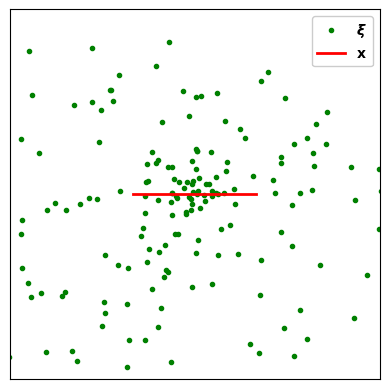

In [8]:
# Plot of all field points. Displays only the close ones.
# plt.plot(field_points[:, 0], field_points[:, 1], '.g', label=r'$\boldsymbol{\xi}$')
# plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r-', linewidth=2, label=r'$\mathbf{x}$')
# plt.gca().set_aspect('equal')
# plt.xlim(-1.0, 2.0)
# plt.ylim(-1.5, 1.5)
# plt.xticks([])
# plt.yticks([])
# plt.legend(loc='upper right', framealpha=1)
# plt.show()

In [9]:
# Computation of influence coefficients using the three implemented methods.
analytical, gauss = [np.empty(field_points.shape) for _ in range(2)]
analytical_numba, gauss_numba = [np.empty(field_points.shape) for _ in range(2)]
analytical_fortran, gauss_fortran = [np.empty(field_points.shape) for _ in range(2)]

for i in range(len(field_points)):
    analytical[i] = e.get_influence_coefficients(field_points[i], method='analytical')
    analytical_numba[i] = e.get_influence_coefficients(field_points[i], method='analytical', boost='numba')
    analytical_fortran[i] = e.get_influence_coefficients(field_points[i], method='analytical', boost='fortran')
    gauss[i] = e.get_influence_coefficients(field_points[i], method='gauss')
    gauss_numba[i] = e.get_influence_coefficients(field_points[i], method='gauss', boost='numba')
    gauss_fortran[i] = e.get_influence_coefficients(field_points[i], method='gauss', boost='fortran')

In [10]:
# Assert that the computations with or without boost are giving the same result.
err_analytical_numba = np.abs(analytical_numba - analytical)
err_analytical_fortran = np.abs(analytical_fortran - analytical)
err_gauss_numba = np.abs(gauss_numba - gauss)
err_gauss_fortran = np.abs(gauss_fortran - gauss)

assert np.max(err_analytical_numba) < eps
assert np.max(err_analytical_fortran) < eps
assert np.max(err_gauss_numba) < eps
assert np.max(err_gauss_fortran) < eps

In [11]:
# Evaluation of time required by each method to compute the influence coefficients for each field point.
# It can take some time. It's a good idea to save it and load it later.

# time_analytical, time_gauss = [np.empty(len(field_points)) for _ in range(2)]
# time_analytical_numba, time_gauss_numba = [np.empty(len(field_points)) for _ in range(2)]
# time_analytical_fortran, time_gauss_fortran = [np.empty(len(field_points)) for _ in range(2)]

# for i in range(len(field_points)):
#     time_analytical[i] = get_time(e, field_points[i], method='analytical')
#     time_analytical_numba[i] = get_time(e, field_points[i], method='analytical', boost='numba')
#     time_analytical_fortran[i] = get_time(e, field_points[i], method='analytical', boost='fortran')
#     time_gauss[i] = get_time(e, field_points[i], method='gauss')
#     time_gauss_numba[i] = get_time(e, field_points[i], method='gauss', boost='numba')
#     time_gauss_fortran[i] = get_time(e, field_points[i], method='gauss', boost='fortran')

# np.save('time_analytical.npy', time_analytical)
# np.save('time_analytical_numba.npy', time_analytical_numba)
# np.save('time_analytical_fortran.npy', time_analytical_fortran)
# np.save('time_gauss.npy', time_gauss)
# np.save('time_gauss_numba.npy', time_gauss_numba)
# np.save('time_gauss_fortran.npy', time_gauss_fortran)

In [12]:
# Load time evaluation data.
time_analytical = np.load('time_analytical.npy')
time_analytical_numba = np.load('time_analytical_numba.npy')
time_analytical_fortran = np.load('time_analytical_fortran.npy')
time_gauss = np.load('time_gauss.npy')
time_gauss_numba = np.load('time_gauss_numba.npy')
time_gauss_fortran = np.load('time_gauss_fortran.npy')

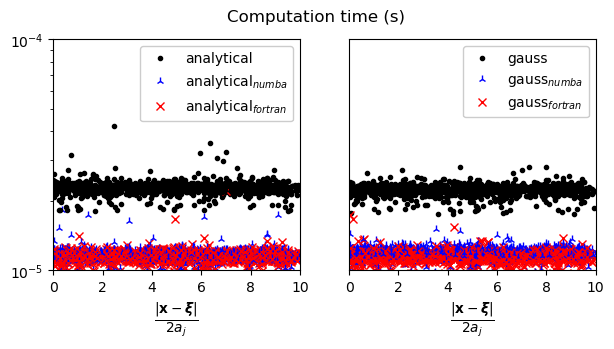

In [16]:
# Plot evaluation time as a function of the distance between the field point and the element node.

def alternate_plot(ax, time, time_numba, time_fortran, method='analytical'):
    # Alternate the plots, so one set does not overlap the other.

    for i in range(len(norm_distances)):
        if i == 0:
            ax.semilogy(norm_distances[i], time[i], 'k.', label=method)
            ax.semilogy(norm_distances[i], time_numba[i], 'b2', label=method+'$_{numba}$')
            ax.semilogy(norm_distances[i], time_fortran[i], 'rx', label=method+'$_{fortran}$')
        else:
            ax.semilogy(norm_distances[i], time[i], 'k.')
            ax.semilogy(norm_distances[i], time_numba[i], 'b2')
            ax.semilogy(norm_distances[i], time_fortran[i], 'rx')
    
    ax.set_xlabel(r'$\frac{|\mathbf{x} - \boldsymbol{\xi}|}{2a_j}$', fontsize=14)
    ax.legend(loc='upper right', framealpha=1)
    ax.set_xlim((0.0, 10.0))
    ax.set_ylim((1.0e-5, 1.0e-4))

fig, ax = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle('Computation time (s)')

alternate_plot(ax[0], time_analytical, time_analytical_numba, time_analytical_fortran, 'analytical')
alternate_plot(ax[1], time_gauss, time_gauss_numba, time_gauss_fortran, 'gauss')

ax[1].yaxis.set_visible(False)

# plt.savefig('computation_time.svg', bbox_inches='tight')
plt.show()

In [14]:
time_ratio_analytical_numba = np.mean(time_analytical_numba) / np.mean(time_analytical) * 100.0
time_ratio_gauss_numba = np.mean(time_gauss_numba) / np.mean(time_gauss) * 100.0

time_ratio_analytical_fortran = np.mean(time_analytical_fortran) / np.mean(time_analytical) * 100.0
time_ratio_gauss_fortran = np.mean(time_gauss_fortran) / np.mean(time_gauss) * 100.0

time_ratio2_analytical_fortran = np.mean(time_analytical_fortran) / np.mean(time_analytical_numba) * 100.0
time_ratio2_gauss_fortran = np.mean(time_gauss_fortran) / np.mean(time_gauss_numba) * 100.0

print(f'On average, analytical integration boosted by Numba takes {time_ratio_analytical_numba:.0f}% of time of the same procedure without boost.')
print(f'On average, Gauss-Legendre quadrature boosted by Numba takes {time_ratio_gauss_numba:.0f}% of time of the same procedure without boost.')
print()
print(f'On average, analytical integration boosted by Fortran takes {time_ratio_analytical_fortran:.0f}% of time of the same procedure without boost.')
print(f'On average, Gauss-Legendre quadrature boosted by Fortran takes {time_ratio_gauss_fortran:.0f}% of time of the same procedure without boost.')
print()
print(f'On average, analytical integration boosted by Fortran takes {time_ratio2_analytical_fortran:.0f}% of time of the same procedure boosted by Numba.')
print(f'On average, Gauss-Legendre quadrature boosted by Fortran takes {time_ratio2_gauss_fortran:.0f}% of time of the same procedure boosted by Numba.')

On average, analytical integration boosted by Numba takes 51% of time of the same procedure without boost.
On average, Gauss-Legendre quadrature boosted by Numba takes 54% of time of the same procedure without boost.

On average, analytical integration boosted by Fortran takes 50% of time of the same procedure without boost.
On average, Gauss-Legendre quadrature boosted by Fortran takes 52% of time of the same procedure without boost.

On average, analytical integration boosted by Fortran takes 99% of time of the same procedure boosted by Numba.
On average, Gauss-Legendre quadrature boosted by Fortran takes 96% of time of the same procedure boosted by Numba.
